In [1]:
import numpy as np
import scipy.stats as sps
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Global Variables
WAD = 10**18
RAY = 10**27
RAD = 10**45
SPY = 31536000 # seconds per year
MAX = 2**255
SPH = 60*60

In [3]:
#assume
halflife=SPY/52 #weeklong halflife
alpha = int(np.power(.5,float(1/halflife))*RAY)

In [4]:
params = {
    'expected_lag': [10],
    'minimum_period': [SPH],
    'correction_wt': [0.5],
    'noise_wt': [0.001],
    'alpha': [alpha] #in 1/RAY
}

params

{'expected_lag': [10],
 'minimum_period': [3600],
 'correction_wt': [0.5],
 'noise_wt': [0.001],
 'alpha': [999998857063901981428416512]}

In [5]:
state = {
    'price': int(RAY), #in 1/RAY
    'target': int(RAY), #in 1/RAY
    'error': {'new':0, 'old':0}, #in 1/RAY
    'leaky_integral': 0, #in 1/RAY * seconds (?)
    'integral': 0,  
    'Dt': 0, #seconds
    'timestamp': dt.datetime.now() #date
}

state

{'price': 1000000000000000000000000000,
 'target': 1000000000000000000000000000,
 'error': {'new': 0, 'old': 0},
 'leaky_integral': 0,
 'integral': 0,
 'Dt': 0,
 'timestamp': datetime.datetime(2020, 8, 30, 14, 35, 1, 249916)}

In [6]:
def event(params, step, sL, s):

    error =s['price']-s['target']
    delta_time = sps.expon.rvs(loc = params['minimum_period'], scale = params['expected_lag'])

    return({'error':error, 'delta_time': delta_time})

def time_move(params, step, sL, s, _input):

    seconds = _input['delta_time']
    td = dt.timedelta(days=0, seconds=seconds)
    key = 'timestamp'
    value = s['timestamp']+td

    return(key, value)

def store_Dt(params, step, sL, s, _input):

    key = 'Dt'
    value = np.floor(_input['delta_time'])

    return(key, value)

def store_error(params, step, sL, s, _input):

    key = 'error'

    new_error = _input['error']
    old_error = s['error']['new']

    value = {'new':new_error, 'old':old_error}

    return(key, value)

def update_integral(params, step, sL, s, _input):
    """
    Given integral previous value I, and the last two errors [new_error, old_error] and time pased Dt
        A = Dt*(new_error+old_error)/2
        I = I + A  
    """

    new_error = s['error']['new']
    old_error = s['error']['old']

    e_bar = int((new_error+old_error)/2)

    Dt = s['Dt']

    area = e_bar*Dt

    value = s['integral']+area
    key = 'integral'

    return(key, value)

def update_leaky_integral(params, step, sL, s, _input):
    """
    Given integral previous value I, and the last two errors [new_error, old_error] and time pased Dt
        A = Dt*(new_error+old_error)/2
        I = alpha^Dt *I + A  
    """

    new_error = s['error']['new']
    old_error = s['error']['old']

    e_bar = int((new_error+old_error)/2)

    Dt = s['Dt']

    area = e_bar*Dt

    alpha = params['alpha']
    remaing_frac = float(alpha/RAY)**Dt

    remaining = int(remaing_frac*s['leaky_integral'])

    value = remaining+area
    key = 'leaky_integral'

    return(key, value)

def martingale(params, step, sL, s):

    theta = params['correction_wt']
    noise = np.random.randn()*params['noise_wt']
    raw_price = float(s['price'])/RAY
    raw_target = float(s['target'])/RAY

    raw_price = theta*raw_target+(1-theta)*raw_price + noise
    
    return({'raw_price':raw_price})

def price_move(params, step, sL, s, _input):

    raw_price = _input['raw_price']
    price = int(raw_price*RAY)

    key = 'price'
    value = price

    return(key, value)

In [7]:
PSUBs = [
    {
        'policies': {
            'update_event': event
        },
        'variables': {
            'error': store_error,
            'timestamp':time_move,
            'Dt': store_Dt
        }
    },
    {
        'policies': {},
        'variables': {
            'leaky_integral': update_leaky_integral,
            'integral': update_integral,
        }
    },
    {
        'policies': {
            'martingale': martingale        },
        'variables': {
            'price': price_move,
        }
    },
]

In [8]:
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim

sim_config = config_sim (
    {
        'T': range(100),
        'N': 3,
        'M': params
    }
)

In [9]:

exp = Experiment()

exp.append_configs(
    sim_configs=sim_config,
    initial_state=state,
    partial_state_update_blocks=PSUBs
)

from cadCAD import configs
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.local_mode)
executor = Executor(exec_context, 2 * configs)
raw_result, tensor, _ = executor.execute()

df = pd.DataFrame(raw_result)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (100, 5, 6, 7)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0, 0, 0]
SubsetIDs: [0, 0, 0, 0, 0, 0]
Ns       : [0, 1, 2, 0, 1, 2]
ExpIDs   : [0, 0, 0, 0, 0, 0]
Execution Mode: parallelized
Total execution time: 0.27s


In [10]:
rdf = df[df.substep == 3].copy()

In [17]:
rdf.tail()

,price,target,error,leaky_integral,integral,Dt,timestamp,simulation,subset,run,substep,timestep,normed_integral,normed_leaky_integral,normed_price,normed_target,normed_error,new_error,old_error
1793,1001855285449772658512101376,1000000000000000000000000000,"{'new': 878664711086362138247168, 'old': -3033...",-1.118723e+29,-1.206134e+29,3600.0,2020-09-03 14:51:03.394141,0,0,3,3,96,-0.033504,-0.031076,1.001855,1.0,0.001855,0.000879,-0.000303
1796,999491105329412717651427328,1000000000000000000000000000,"{'new': 1855285449772658512101376, 'old': 8786...",-1.064799e+29,-1.156814e+29,3608.0,2020-09-03 15:51:11.809204,0,0,3,3,97,-0.032134,-0.029578,0.999491,1.0,-0.000509,0.001855,0.000879
1799,1000514477240324084195131392,1000000000000000000000000000,"{'new': -508894670587282348572672, 'old': 1855...",-1.036191e+29,-1.132579e+29,3600.0,2020-09-03 16:51:12.451555,0,0,3,3,98,-0.031461,-0.028783,1.000514,1.0,0.000514,-0.000509,0.001855
1802,1000724417510325152884195328,1000000000000000000000000000,"{'new': 514477240324084195131392, 'old': -5088...",-1.031828e+29,-1.132478e+29,3607.0,2020-09-03 17:51:19.918716,0,0,3,3,99,-0.031458,-0.028662,1.000724,1.0,0.000724,0.000514,-0.000509
1805,1001149646002909936938385408,1000000000000000000000000000,"{'new': 724417510325152884195328, 'old': 51447...",-1.005232e+29,-1.110129e+29,3608.0,2020-09-03 18:51:28.632760,0,0,3,3,100,-0.030837,-0.027923,1.001150,1.0,0.001150,0.000724,0.000514


In [12]:
rdf['normed_integral'] = rdf.integral.apply(lambda x: x/(RAY*SPH))
rdf['normed_leaky_integral'] = rdf.leaky_integral.apply(lambda x: x/(RAY*SPH))
rdf['normed_price'] = rdf.price.apply(lambda x: x/RAY)
rdf['normed_target'] = rdf.target.apply(lambda x: x/RAY)
rdf['normed_error']  = rdf.normed_price-rdf.normed_target

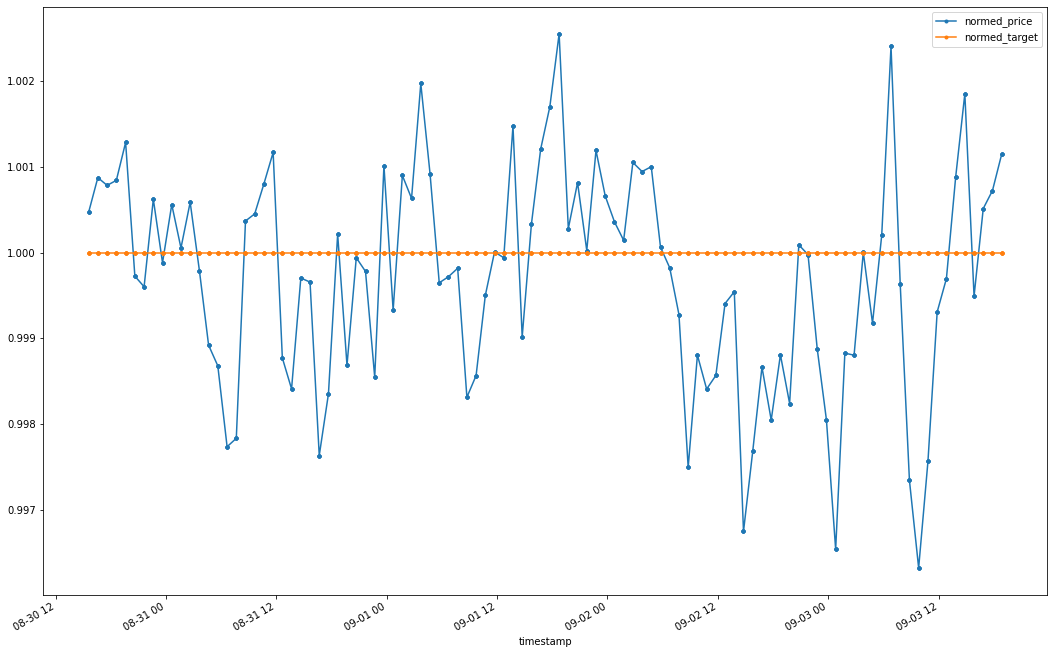

In [13]:
plt.figure(figsize=(18, 12))
rdf.plot(x='timestamp', y=['normed_price','normed_target'], marker='.', ax=plt.gca())

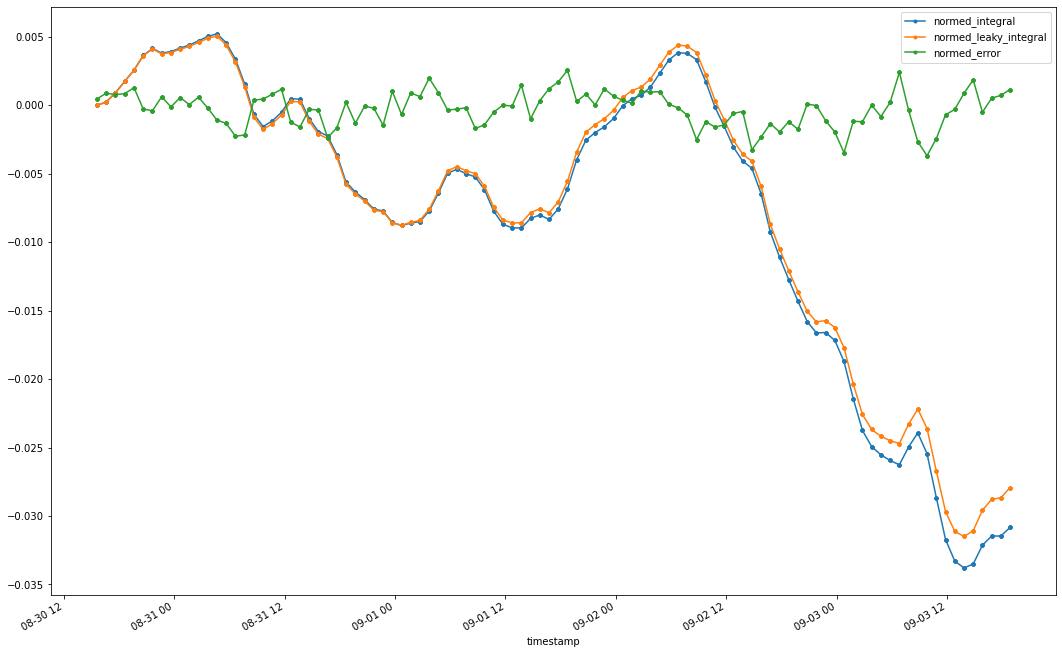

In [14]:
plt.figure(figsize=(18, 12))
rdf.plot(x='timestamp', y=['normed_integral', 'normed_leaky_integral','normed_error'], marker='.', ax=plt.gca())

In [15]:
rdf['new_error'] = rdf.error.apply(lambda x: float(x['new']/RAY))
rdf['old_error'] = rdf.error.apply(lambda x: float(x['old']/RAY))

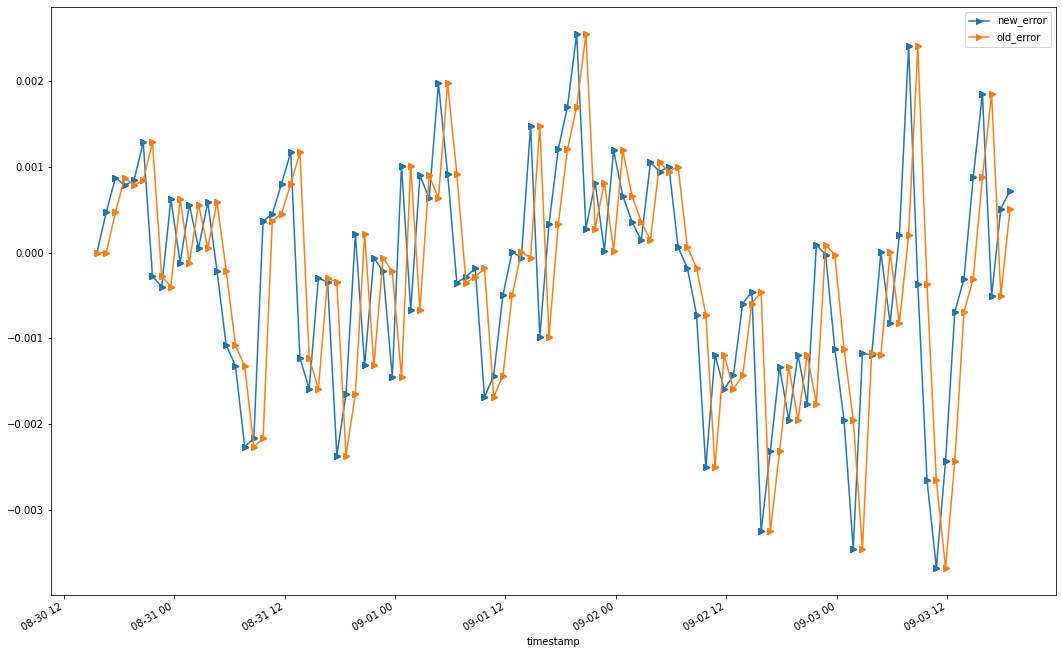

In [16]:
plt.figure(figsize=(18, 12))
rdf[['new_error','old_error','timestamp']].plot(x='timestamp', marker='>', ax=plt.gca())